The following code implements the well known simple moving average (SMA) trading strategy. The rubric is as follows:

- a slow-moving average and a fast-moving average are calculated for historical data of a stock
- 13 days and 48 days are the optimal rolling averages according to http://etfhq.com/blog/2013/01/15/golden-cross-which-is-the-best/
- when the fast-moving average crosses *over* the slow moving average, a 'buy' signal is generated, since it suggests the stock is currently outperforming itself
- when the fast-moving average crosses *under* the slow moving average, a 'sell' signal is generated, for the converse reason
- this process smoothes the stock's behaviour by reducing the noise proportionally to the rolling average period chosen

We begin by extracting relevant data from Yahoo Finance for a 5 year period of Amazon stock:

In [16]:
from pandas_datareader import data as web
from math import nan
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt

In [17]:
ticker = 'AMZN'
start = datetime.datetime(2015, 5, 1)
end = datetime.datetime(2020, 12, 2)
stock = web.DataReader(ticker, 'yahoo', start, end)
stock.head(3)  # display the beginning of the Amazon stock dataset

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-05-01,425.640015,416.000000,423.820007,422.869995,3565800,422.869995
2015-05-04,429.769989,422.420013,424.799988,423.040009,2270400,423.040009
2015-05-05,427.510010,421.019989,422.850006,421.190002,2856400,421.190002


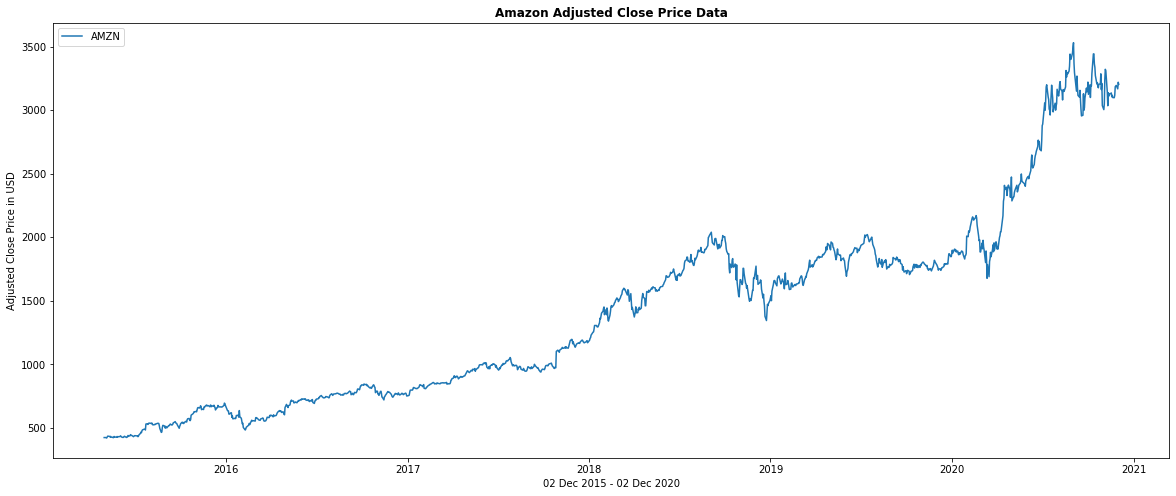

In [18]:
# visualisation
plt.figure(figsize=(20, 8))
plt.plot(stock['Adj Close'], label = 'AMZN')
plt.xlabel('02 Dec 2015 - 02 Dec 2020')
plt.ylabel('Adjusted Close Price in USD')
plt.title('Amazon Adjusted Close Price Data', fontweight = 'bold')
plt.legend(loc='upper left')
plt.show()

A study by ETF HQ using 300 years of data discovered that trading the crossovers of the 13-day and 48.5-day averages produced the largest returns. 48 days have been used instead of 48.5 for to simplify the code, since the uncertainty is large on the 'optimal SMA'. Source: http://etfhq.com/blog/2013/01/15/golden-cross-which-is-the-best/.

Thus, we now implement the strategy, starting with defining our SMAs:

In [19]:
# calculating the simle moving averages for 13 and 48 days
sma_13 = pd.DataFrame()
sma_13['Adj Close Price'] = stock['Adj Close'].rolling(13).mean()

sma_48 = pd.DataFrame()
sma_48['Adj Close Price'] = stock['Adj Close'].rolling(48).mean()

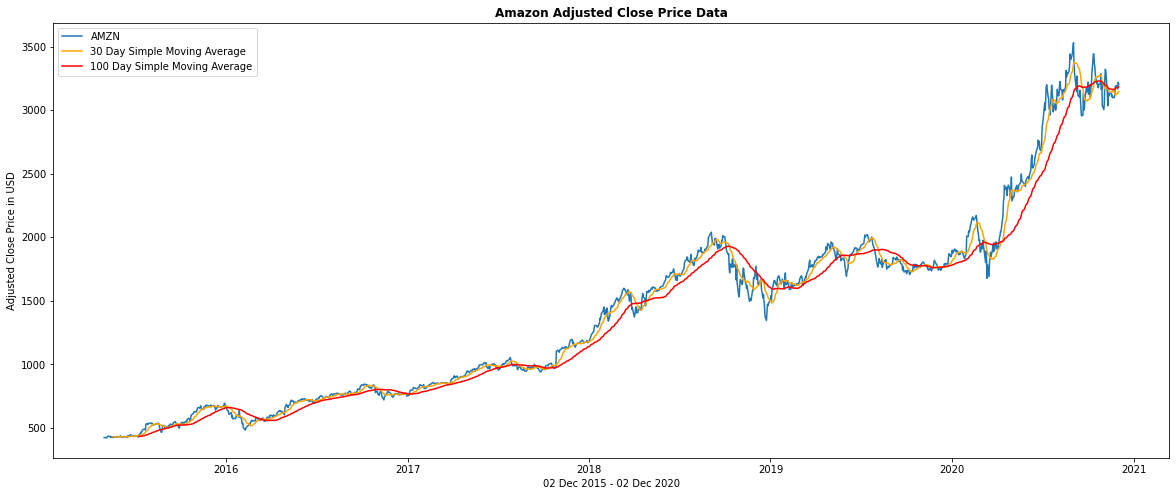

In [28]:
# visualisation
plt.figure(figsize=(20, 8))
plt.plot(stock['Adj Close'], label = 'AMZN')
plt.plot(sma_13['Adj Close Price'], label='30 Day Simple Moving Average', c='orange')
plt.plot(sma_48['Adj Close Price'], label='100 Day Simple Moving Average', c='red')
plt.title('Amazon Adjusted Close Price Data', fontweight = 'bold')
plt.xlabel('02 Dec 2015 - 02 Dec 2020')
plt.ylabel('Adjusted Close Price in USD')
plt.legend()
plt.show()

In [31]:
# combining the stock, 30_sma and 100_sma into one dataframe
combined_df = pd.DataFrame()
combined_df['stock'] = stock['Adj Close']
combined_df['sma_13'] = sma_13['Adj Close Price']
combined_df['sma_48'] = sma_48['Adj Close Price']

Generating buy and sell signal based on SMA cross-overs and cross-unders of the two SMAs:

In [22]:
def crossover_strategy(data):
    buy = []
    sell = []
    current_state = -1

    for i in range(len(data)):
        if data['sma_13'][i] > data['sma_48'][i]:  # buy if sma_13 > sma_48
            if current_state != 0:
                buy.append(data['stock'][i])
                sell.append(nan)
                current_state = 0
            else:
                buy.append(nan)
                sell.append(nan)
        elif data['sma_13'][i] < data['sma_48'][i]:  # sell if sma_13 < sma_48
            if current_state != 1:
                buy.append(nan)
                sell.append(data['stock'][i])
                current_state = 1
            else:
                buy.append(nan)
                sell.append(nan)
        else:  # equal
            buy.append(nan)
            sell.append(nan)

    return buy, sell

In [23]:
# appending buy and sell datapoints according to the strategy
crossover_strategy = crossover_strategy(combined_df)
combined_df['Buy_Price'] = crossover_strategy[0]
combined_df['Sell_Price'] = crossover_strategy[1]

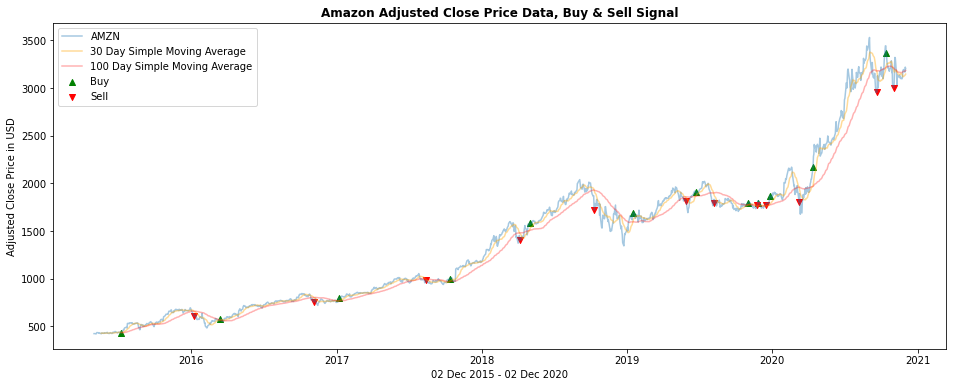

In [30]:
# visualisation
plt.figure(figsize=(16,6))
plt.plot(combined_df['stock'],label = 'AMZN', alpha = 0.4,)
plt.plot(combined_df['sma_13'],label= '30 Day Simple Moving Average', alpha = 0.4, c='orange')
plt.plot(combined_df['sma_48'], label= '100 Day Simple Moving Average', alpha = 0.3, c='red')
plt.scatter(combined_df.index,combined_df['Buy_Price'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(combined_df.index,combined_df['Sell_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.xlabel('02 Dec 2015 - 02 Dec 2020')
plt.ylabel('Adjusted Close Price in USD')
plt.title('Amazon Adjusted Close Price Data, Buy & Sell Signal', fontweight = 'bold')
plt.legend()
plt.show()

The next stage is to adapt the strategy to the cerebro backtrader library for backtesting: https://www.backtrader.com/docu/cerebro/